In [1]:
# let's play with they spin isochrones from Spada & Lanzafame (2020)
# https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..76S/abstract

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

import matplotlib.pyplot as plt


In [9]:
df = pd.read_csv('SL20_tblA1.txt')
df.columns


Index(['Mass', 'B_V', 'T0.10', 'T0.12', 'T0.15', 'T0.20', 'T0.22', 'T0.25',
       'T0.30', 'T0.40', 'T0.50', 'T0.60', 'T0.70', 'T1.00', 'T1.50', 'T2.00',
       'T2.50', 'T4.00', 'T4.57'],
      dtype='object')

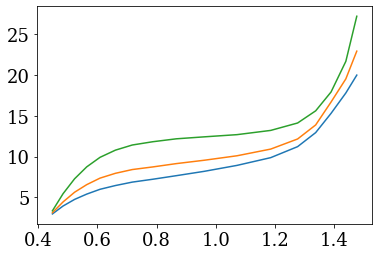

In [11]:
plt.plot(df['B_V'], df['T0.40'])
plt.plot(df['B_V'], df['T0.60'])
plt.plot(df['B_V'], df['T1.00'])

Text(0, 0.5, 'Period (days)')

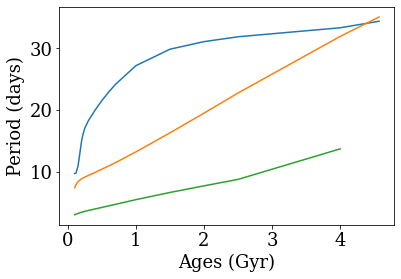

In [18]:
ages = [0.10,0.12,0.15,0.20,0.22,0.25,0.30,0.40,0.50,0.60,0.70,1.00,1.50,2.00,2.50,4.00,4.57]

plt.plot(ages, df.iloc[0, 2:])
plt.plot(ages, df.iloc[5, 2:])
plt.plot(ages, df.iloc[15, 2:])
plt.xlabel('Ages (Gyr)')
plt.ylabel('Period (days)')

In [14]:
df.iloc[5, 2:]

T0.10     7.38
T0.12     7.88
T0.15     8.38
T0.20     8.83
T0.22     8.96
T0.25     9.12
T0.30     9.38
T0.40     9.87
T0.50    10.40
T0.60    10.92
T0.70    11.46
T1.00    13.21
T1.50    16.30
T2.00    19.50
T2.50    22.77
T4.00    31.96
T4.57    35.11
Name: 5, dtype: float64